In [1]:
import itertools
import sys
import copy
import time
import numpy as np
import scipy
import qiskit
from qiskit import transpile
from qiskit import QuantumRegister, ClassicalRegister, Aer, transpile
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import h5py
import vcg
import vcg.qstate as qstate
import vcg.circuit as vcgc
from vcg.circuit import VcgCirc, AnsatzCirc
from vcg.cost import Cost
from vcg.ansatz import FlexibleAnsatz
from vcg.backend import IBMQBackend
import noisyopt
import qutip
import matplotlib.pyplot as plt
import matplotlib
import pickle

/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_3740/667825247.py:10: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [2]:
matplotlib.style.use("../style.mplstyle")

# Init various problem paramters and load Backend

In [4]:
backend = IBMQBackend('ibm_nairobi', "NicOpen")

ibmqfactory.load_account:WARNING:2022-06-22 15:06:34,880: Credentials are already in use. The existing account in the session will be replaced.


IBM Backend ibm_nairobi loaded at date/time: 2022-06-22 15:06:39


In [5]:
b_qubits = [q for q in range(backend.get_number_qubits())]
rho_qubits = [0, 1]
trace_out = [q for q in b_qubits if q not in rho_qubits]
n = len(rho_qubits)

# Functions to create cost evaluation circuits

In [6]:
def make_hadamard_rho_circ(h_qubits, num_ids, device):
    """
    Applies hadamard to [h_qubit] followed by [num_ids]
    identities.
    Transpiles circuit to native gates on [device].
    """
    n_device = device.get_number_qubits()
    qubits = list(range(n_device))
    circ = AnsatzCirc(n_device)
    circ.h(h_qubits[0])
    circ.barrier(qubits)
    for _ in range(num_ids):
        circ.id(h_qubits[0])
        circ.barrier(qubits)
    circ.cnot(h_qubits[0], h_qubits[1])
    circ.barrier(qubits)
    
    #t_circ = transpile(circ, device.backend, optimization_level=0)
    
    return circ

rho_prep_circ = make_hadamard_rho_circ(rho_qubits, 20, backend)
rho_prep_circ.draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q_0: ┤ H ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
     └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
q_1: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_2: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_3: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_4: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_5: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_6: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«     ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«     └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«q_1: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_2: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_3: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_4: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_5: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_6: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«     ┌───┐ ░ ┌───┐ ░ ┌───┐ ░       ░ 
«q_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░───■───░─
«     └───┘ ░ └───┘ ░ └───┘ ░ ┌─┴─┐ ░ 
«q_1: ──────░───────░───────░─┤ X ├─░─
«           ░       ░       ░ └───┘ ░ 
«q_2: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_3: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_4: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_5: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_6: ──────░───────░───────░───────░─
«           ░       ░       ░       ░

In [7]:
# generate \rho_ideal from this
# copying necessary to not add 'get_statevector' tag to circuit in place
circ = copy.deepcopy(rho_prep_circ)
phi = circ.get_statevector()
rho = qiskit.quantum_info.partial_trace(phi, trace_out)
rp = np.real(rho.purity())
rp

1.0

In [8]:
rho

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))


In [9]:
def make_sigma_ansatz_circuits(pvec, ansatz, u_qubits, udg_qubits, device, n, nb):
    """
    Creates circuit.
    """
    # build the ansatz circuit on [n + nb] qubits
    ansatz.update_parameters(pvec)
    ansatz_circ = ansatz.build_circ(n + nb)
    
    # build circuits for [device]
    n_device = device.get_number_qubits()
    qubits = list(range(n_device))
    u_circ = AnsatzCirc(n_device)
    udg_circ = AnsatzCirc(n_device)
    
    # compose u_circ across [u_qubits] then transpile
    u_circ.compose(ansatz_circ, u_qubits, inplace=True)
    #u_tcirc = transpile(u_circ, device.backend, optimization_level=0)
    # compose udg_circ across [udg_qubits] in reverse
    #sig_q = copy.deepcopy(udg_qubits[0:n])
    #ancilla = copy.deepcopy(udg_qubits[n:])
    #sig_q.reverse()
    #re_ordered_q = sig_q + ancilla
    udg_circ.compose(ansatz_circ.inverse(), udg_qubits, inplace=True)
    # must reverse again because it propogates outside of fuctino scope for some reason...
    #udg_tcirc = transpile(udg_circ, device.backend, optimization_level=0)
    
    return u_circ, udg_circ

# test that u and udg and properly coded
nb = 1
ansatz = FlexibleAnsatz(n + nb, 'hef2d')
ansatz.build_circ(n + nb).draw()
u_circ, udg_circ = make_sigma_ansatz_circuits(np.random.random(30), ansatz, [0, 1, 2], [0, 1, 2], backend, n, nb)
u = u_circ.get_unitary()
udg = udg_circ.get_unitary()
check_id = np.isclose(np.matmul(u, udg), np.identity(2**backend.get_number_qubits())).all()
check_id

True

In [10]:
nb = 1
ansatz = FlexibleAnsatz(n + nb, 'hef2d')
u_qubits = [0, 1, 2]
udg_qubits = [0, 1, 3]
u_circ, udg_circ = make_sigma_ansatz_circuits(np.random.random(30), ansatz, u_qubits, udg_qubits, backend, n, nb)

In [11]:
# generate \sigma from this
# copying necessary to not add 'get_statevector' tag to circuit in place
circ = copy.deepcopy(u_circ)
psi = circ.get_statevector(False)
sigma = qiskit.quantum_info.partial_trace(psi, trace_out)

In [12]:
sigma

DensityMatrix([[ 0.30139729+0.j        ,  0.06286166-0.13014778j,
                 0.14966196-0.15458417j, -0.09189887-0.02263867j],
               [ 0.06286166+0.13014778j,  0.31001211+0.j        ,
                -0.06691691+0.1359352j ,  0.08908484-0.00195897j],
               [ 0.14966196+0.15458417j, -0.06691691-0.1359352j ,
                 0.31109549+0.j        , -0.08321914-0.12981627j],
               [-0.09189887+0.02263867j,  0.08908484+0.00195897j,
                -0.08321914+0.12981627j,  0.07749511+0.j        ]],
              dims=(2, 2))


In [13]:
# check that udg also can generate \sigma
circ = udg_circ.inverse()
udg_circ_inverse = AnsatzCirc(backend.get_number_qubits())
udg_circ_inverse.compose(circ, inplace = True)
psi2 = udg_circ_inverse.get_statevector()
sigma2 = qiskit.quantum_info.partial_trace(psi2, trace_out)

In [14]:
sigma2

DensityMatrix([[ 0.30139729+0.j        ,  0.06286166-0.13014778j,
                 0.14966196-0.15458417j, -0.09189887-0.02263867j],
               [ 0.06286166+0.13014778j,  0.31001211+0.j        ,
                -0.06691691+0.1359352j ,  0.08908484-0.00195897j],
               [ 0.14966196+0.15458417j, -0.06691691-0.1359352j ,
                 0.31109549+0.j        , -0.08321914-0.12981627j],
               [-0.09189887+0.02263867j,  0.08908484+0.00195897j,
                -0.08321914+0.12981627j,  0.07749511+0.j        ]],
              dims=(2, 2))


In [15]:
sigma == sigma2

True

In [16]:
qiskit.quantum_info.state_fidelity(sigma, sigma2)

1.0

In [17]:
print(sigma.purity())
print(sigma2.purity())

(0.5513673322506443+0j)
(0.5513673322506443+0j)


In [18]:
def make_sigma_purity_circ(u_circ, ghz_qubits, udg_circ, udg_qubits, device):
    """
    Creates the circuit we want to make...
    """
    # generate circuit and append rho preparation
    n_device = device.get_number_qubits()
    circ = AnsatzCirc(n_device, len(udg_qubits))
    circ.compose(u_circ, inplace = True)
    
    # prepare GHZ state on [ghz_qubits]
    circ.h(ghz_qubits[0])
    for i in range(len(ghz_qubits) - 1):
        circ.cnot(ghz_qubits[i], ghz_qubits[i + 1])
        
    # apply Udg circuit
    circ.compose(udg_circ, inplace = True)
    
    # apply measurements
    for idx, q in enumerate(udg_qubits):
        circ.measure(q, idx)
        
    # transpile all
    #t_circ = transpile(circ, device.backend, optimization_level=0)
        
    return circ

In [19]:
ghz_qubits = [3, 5]
sp_circ = make_sigma_purity_circ(u_circ, ghz_qubits, udg_circ, udg_qubits, backend)

# test if purity is correct
shots = int(1e5)

def compute_shot_cost(circ, m_qubits, shots):
    """
    Computes shot cost.
    """
    psi = circ.get_statevector(True)
    counts = psi.sample_counts(shots)
    num_all_zero = 0
    tot_counts = 0
    for key, value in counts.items():
        tot_counts += value
        if all([key[j] == '0' for j in m_qubits]):
            num_all_zero += value
    
    return num_all_zero / tot_counts

print(f"ideal sigma purity: {np.real(sigma.purity())}")
sp = 2**nb * compute_shot_cost(sp_circ, udg_qubits, shots)
print(f"{shots} shots sigma purity: {sp}")

ideal sigma purity: 0.5513673322506443
100000 shots sigma purity: 0.55378


In [20]:
def make_msl_cross_circ(sigma_prep_circ, ghz_qubits, udg_circ, udg_qubits, device):
    """
    Creates the circuit we want to make...
    """
    # generate circuit and append sigma preparation
    n_device = device.get_number_qubits()
    circ = AnsatzCirc(n_device, len(udg_qubits))
    circ.compose(sigma_prep_circ, inplace = True)
    
    # prepare GHZ state on [ghz_qubits]
    circ.h(ghz_qubits[0])
    for i in range(len(ghz_qubits) - 1):
        circ.cnot(ghz_qubits[i], ghz_qubits[i + 1])
        
    # barrier?
    #circ.barrier(udg_qubits)
        
    # apply Udg circuit
    circ.compose(udg_circ, inplace = True)
    
    # apply measurements
    for idx, q in enumerate(udg_qubits):
        circ.measure(q, idx)
        
    # transpile all
    #t_circ = transpile(circ, device.backend, optimization_level=0)
        
    return circ

In [21]:
ideal_overlap = np.real(np.trace(np.matmul(sigma, rho)))
print(f"ideal overlap: {ideal_overlap}")

cross_circ = make_msl_cross_circ(rho_prep_circ, ghz_qubits, udg_circ, udg_qubits, backend)
shot_overlap = 2**nb * compute_shot_cost(cross_circ, udg_qubits, shots)

print(f"{shots} shot overlap: {shot_overlap}")

ideal overlap: 0.09754733340562508
100000 shot overlap: 0.09832


In [22]:
def compute_msl_shot_and_ideal_cost(pvec, ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits,
                                    ghz_qubits, n, nb, device, hardware=False,
                                    shot_list=None, exact_list=None, params=None):
    """
    Computes shot cost as well as exact cost from direct simulation.
    """
    # ========================================
    # build pre-requisite circuits
    # ========================================
    if params is not None:
        params.append(pvec)
    # U and Udg to prepare sigma
    u_circ, udg_circ = make_sigma_ansatz_circuits(pvec, ansatz, u_qubits, udg_qubits, device, n, nb)
    # sigma purity circuit
    sp_circ = make_sigma_purity_circ(u_circ, ghz_qubits, udg_circ, udg_qubits, device)
    sp_t_circ = transpile(sp_circ, device.backend, optimization_level=0)
    # cross term circuit
    cross_circ = make_msl_cross_circ(rho_prep_circ, ghz_qubits, udg_circ, udg_qubits, device)
    cross_t_circ = transpile(cross_circ, device.backend, optimization_level=0)
    
    # ========================================
    # compute shot cost (across 80k shots)
    # ========================================
    shots = 10000
    gauges = 10
    # compute via simualtor
    if hardware == False:
        # submit simulator job
        d = 2**nb
        sp_estimate = d * compute_shot_cost(sp_circ, udg_qubits, shots * gauges)
        cross_estimate = d * compute_shot_cost(cross_circ, udg_qubits, shots * gauges)
    # compute on device in real experiment
    else:
        # submit hardware job to [device]
        circ_submissions = [sp_t_circ for _ in range(gauges)]
        for _ in range(gauges):
            circ_submissions.append(cross_t_circ)
        job = device.submit_job(circ_submissions, 'hardware', shots)
        result = job.result()
        count_list = result.get_counts()
        # compute rho purity cost term
        rp_list = count_list[0:gauges]
        tot_counts = 0
        all_zero_counts = 0
        for count_dict in rp_list:
            for key in count_dict:
                if key == (n + nb) * '0':
                    all_zero_counts += count_dict[key]
                    tot_counts += count_dict[key]
                else:
                    tot_counts += count_dict[key]
        d = 2**nb
        sp_estimate = d * (all_zero_counts / tot_counts)
        # compute cross cost term
        cross_list = count_list[gauges:]
        tot_counts = 0
        all_zero_counts = 0
        for count_dict in cross_list:
            for key in count_dict:
                if key == (n + nb) * '0':
                    all_zero_counts += count_dict[key]
                    tot_counts += count_dict[key]
                else:
                    tot_counts += count_dict[key]
        cross_estimate = d * (all_zero_counts / tot_counts)
    
    # evaluate total shot cost
    print(f"sp_shot_value: {sp_estimate}")
    print(f"cross_shot_value: {cross_estimate}")
    shot_cost = rp + sp_estimate - 2 * cross_estimate
        
    if shot_list is not None:
        shot_list.append(shot_cost)
        
    # ========================================
    # compute idealzied cost from matrices
    # ========================================
    # compute statevector from rho prep circuit
    circ = copy.deepcopy(u_circ)
    psi = circ.get_statevector(False)
    # trace out ancilla to extract rho
    device_qubits = list(range(backend.get_number_qubits()))
    sigma_qubits = u_qubits[n:]
    trace_out = []
    for q in device_qubits:
        if q not in rho_qubits:
            trace_out.append(q)
    sigma = qiskit.quantum_info.partial_trace(psi, trace_out)
    # compute idealized cost
    cross_term = np.real(np.trace(np.matmul(rho, sigma)))
    sp = np.real(sigma.purity())
    print(f"sp_exact_value: {sp}")
    print(f"cross_exact_value: {cross_term}")
    exact_cost = rp + sp - 2 * cross_term
    
    if exact_list is not None:
        exact_list.append(exact_cost)
        
    if hardware == False:        
        return shot_cost, exact_cost
    else:
        return shot_cost, exact_cost, job

In [23]:
list1 = []
list2 = []
params = []
shot_cost, exact_cost = compute_msl_shot_and_ideal_cost(ansatz.get_parameters(), ansatz, rho_prep_circ, rho, rp, u_qubits,
                                                        udg_qubits, ghz_qubits, n, nb, backend, False,
                                                        list1, list2, params)
print(shot_cost, exact_cost)

sp_shot_value: 0.55154
cross_shot_value: 0.09884
sp_exact_value: 0.5513673322506443
cross_exact_value: 0.09754733340562508
1.35386 1.3562726654393942


## We need to perform tomography to find out rho in the first place actually...

In [25]:
def make_rho_purity_tomography_experiment(rho_prep_circ, rho_qubits, device):
    """
    Creates the circuit we want to make...
    """
    # generate circuit and append sigma preparation
    qr = QuantumRegister(device.get_number_qubits())
    circ = AnsatzCirc(qr)
    circ.compose(rho_prep_circ, inplace = True)
        
    # transpile all
    sig_register = [qr[q] for q in  rho_qubits]
    tomography_circs = state_tomography_circuits(circ, sig_register)
    t_circs = []
    for circ in tomography_circs:
        tc = transpile(circ, device.backend, optimization_level=0)
        t_circs.append(tc)
        
    return t_circs

def compute_rho_with_tomography(rho_prep_circ, rho_qubits, device):
    """
    
    """
    # Generate tomography circuits
    qr = QuantumRegister(device.get_number_qubits())
    state_prep_circ = AnsatzCirc(qr)
    state_prep_circ.compose(rho_prep_circ, inplace = True)
    measure_qubits = [qr[q] for q in rho_qubits]
    tomography_circs = state_tomography_circuits(state_prep_circ, measure_qubits)
    # transpile them
    t_circs = []
    for circ in tomography_circs:
        tc = transpile(circ, device.backend, optimization_level=0)
        t_circs.append(tc)
    # perform state tomography to obtain \sigma
    job = backend.submit_job(t_circs)
    result = job.result()
    tomo_fitter = StateTomographyFitter(result, t_circs)
    rho = tomo_fitter.fit(method='lstsq')
    rho = qiskit.quantum_info.DensityMatrix(rho)
    
    return rho

def compute_sigma(pvec, ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits,
                  ghz_qubits, rho_qubits, n, nb, device):
    """
    Computes shot cost as well as exact cost from direct simulation.
    """
    # ========================================
    # build pre-requisite circuits
    # ========================================
    # U and Udg to prepare rho
    u_circ, udg_circ = make_sigma_ansatz_circuits(pvec, ansatz, u_qubits, udg_qubits, device, n, nb)
        
    # ========================================
    # compute idealzied cost from matrices
    # ========================================
    # compute statevector from rho prep circuit
    circ = copy.deepcopy(u_circ)
    psi = circ.get_statevector()
    # trace out ancilla to extract rho
    device_qubits = list(range(backend.get_number_qubits()))
    trace_out = []
    for q in device_qubits:
        if q not in rho_qubits:
            trace_out.append(q)
    sigma = qiskit.quantum_info.partial_trace(psi, trace_out)
        
    return sigma

rp_circs = make_rho_purity_tomography_experiment(rho_prep_circ, rho_qubits, backend)

In [26]:
rho = compute_rho_with_tomography(rho_prep_circ, rho_qubits, backend)
rp = np.real(rho.purity())
rp

0.820151895825814

In [27]:
rho

DensityMatrix([[ 0.4687142 +0.j        , -0.01803623-0.02666591j,
                -0.03170424-0.0081935j ,  0.42196252+0.09049111j],
               [-0.01803623+0.02666591j,  0.02460573+0.j        ,
                 0.00410737+0.00170685j, -0.02060443+0.00047537j],
               [-0.03170424+0.0081935j ,  0.00410737-0.00170685j,
                 0.03798258+0.j        , -0.01948282-0.01388921j],
               [ 0.42196252-0.09049111j, -0.02060443-0.00047537j,
                -0.01948282+0.01388921j,  0.46869749+0.j        ]],
              dims=(2, 2))


In [28]:
#sigma = qiskit.quantum_info.DensityMatrix(sigma)
rp = np.real(rho.purity())
rp

0.820151895825814

In [29]:
list1 = []
list2 = []
params = []
shot_cost, exact_cost, job = compute_msl_shot_and_ideal_cost(ansatz.get_parameters(), ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits, 
                                                        ghz_qubits, n, nb, backend, True, list1, list2, params)
print(shot_cost, exact_cost)

sp_shot_value: 0.49426
cross_shot_value: 0.12616
sp_exact_value: 0.5513673322506443
cross_exact_value: 0.11618922928257874
1.062091895825814 1.1391407695113007


## Perform an optimization over simulator with shots

In [39]:
def compute_msl_shot_and_ideal_cost(pvec, ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits,
                                    ghz_qubits, n, nb, device, hardware=False,
                                    shot_list=None, exact_list=None, params=None):
    """
    Computes shot cost as well as exact cost from direct simulation.
    """
    # ========================================
    # build pre-requisite circuits
    # ========================================
    if params is not None:
        params.append(pvec)
    # U and Udg to prepare sigma
    u_circ, udg_circ = make_sigma_ansatz_circuits(pvec, ansatz, u_qubits, udg_qubits, device, n, nb)
    # sigma purity circuit
    sp_circ = make_sigma_purity_circ(u_circ, ghz_qubits, udg_circ, udg_qubits, device)
    sp_t_circ = transpile(sp_circ, device.backend, optimization_level=0)
    # cross term circuit
    cross_circ = make_msl_cross_circ(rho_prep_circ, ghz_qubits, udg_circ, udg_qubits, device)
    cross_t_circ = transpile(cross_circ, device.backend, optimization_level=0)
    
    # ========================================
    # compute shot cost (across 80k shots)
    # ========================================
    shots = 20000
    gauges = 5
    # compute via simualtor
    if hardware == False:
        # submit simulator job
        d = 2**nb
        sp_estimate = d * compute_shot_cost(sp_circ, udg_qubits, shots * gauges)
        cross_estimate = d * compute_shot_cost(cross_circ, udg_qubits, shots * gauges)
    # compute on device in real experiment
    else:
        # submit hardware job to [device]
        circ_submissions = [sp_t_circ for _ in range(gauges)]
        for _ in range(gauges):
            circ_submissions.append(cross_t_circ)
        job = device.submit_job(circ_submissions, 'hardware', shots)
        result = job.result()
        count_list = result.get_counts()
        # compute rho purity cost term
        rp_list = count_list[0:gauges]
        tot_counts = 0
        all_zero_counts = 0
        for count_dict in rp_list:
            for key in count_dict:
                if key == (n + nb) * '0':
                    all_zero_counts += count_dict[key]
                    tot_counts += count_dict[key]
                else:
                    tot_counts += count_dict[key]
        d = 2**nb
        sp_estimate = d * (all_zero_counts / tot_counts)
        # compute cross cost term
        cross_list = count_list[gauges:]
        tot_counts = 0
        all_zero_counts = 0
        for count_dict in cross_list:
            for key in count_dict:
                if key == (n + nb) * '0':
                    all_zero_counts += count_dict[key]
                    tot_counts += count_dict[key]
                else:
                    tot_counts += count_dict[key]
        cross_estimate = d * (all_zero_counts / tot_counts)
    
    # evaluate total shot cost
    shot_cost = rp + sp_estimate - 2 * cross_estimate
        
    if shot_list is not None:
        shot_list.append(shot_cost)
        
    # ========================================
    # compute idealzied cost from matrices
    # ========================================
    # compute statevector from rho prep circuit
    circ = copy.deepcopy(u_circ)
    psi = circ.get_statevector()
    # trace out ancilla to extract rho
    device_qubits = list(range(backend.get_number_qubits()))
    sigma_qubits = u_qubits[n:]
    trace_out = []
    for q in device_qubits:
        if q not in rho_qubits:
            trace_out.append(q)
    sigma = qiskit.quantum_info.partial_trace(psi, trace_out)
    # compute idealized cost
    cross_term = np.real(np.trace(np.matmul(rho, sigma)))
    sp = np.real(sigma.purity())
    exact_cost = rp + sp - 2 * cross_term
    
    if exact_list is not None:
        exact_list.append(exact_cost)
    
    return shot_cost


def compute_msl_ideal_cost(pvec, ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits,
                           rho_qubits, n, nb, device, exact_list=None):
    """
    Computes shot cost as well as exact cost from direct simulation.
    """
    # ========================================
    # build pre-requisite circuits
    # ========================================
    # U and Udg to prepare rho
    u_circ, udg_circ = make_sigma_ansatz_circuits(pvec, ansatz, u_qubits, udg_qubits, device, n, nb)
        
    # ========================================
    # compute idealzied cost from matrices
    # ========================================
    # compute statevector from rho prep circuit
    circ = copy.deepcopy(u_circ)
    psi = circ.get_statevector()
    # trace out ancilla to extract rho
    device_qubits = list(range(backend.get_number_qubits()))
    trace_out = []
    for q in device_qubits:
        if q not in rho_qubits:
            trace_out.append(q)
    sigma = qiskit.quantum_info.partial_trace(psi, trace_out)
    # compute idealized cost
    cross_term = np.real(np.trace(np.matmul(rho, sigma)))
    exact_cost = rp + np.real(sigma.purity()) - 2 * cross_term
    
    if exact_list is not None:
        exact_list.append(exact_cost)
        
    return exact_cost


def get_rolling_mins(costs, window=10):
    """
    
    """
    mins = []
    bins = int(np.floor(len(costs) / window))
    for b in range(bins):
        cost_window = costs[b * window:(b + 1) * window]
        mins.append(min(cost_window))
        
    cost_window = costs[(bins + 1) * window:]
    if cost_window != []:
        mins.append(min(cost_window))
    
    return np.array(mins)

def compute_optimal_DHS(rho, R):
    """
    Computes D^*_HS when learning [rho]
    with a rank [R] approximation.
    """
    # compute \lambda's and sort them
    lam = np.sort(np.real(np.linalg.eigvals(rho)))
    d = len(lam)
    # compute lowest d - R lowest and R highest
    low_lam = np.array(lam[0:d-R])
    high_lam = np.array(lam[d-R:])
    N = (1 - np.sum(high_lam)) / R
    # compute cost
    #opt_DHS = np.sum(low_lam) + (1/R) * (1 - np.sum(high_lam))**2
    opt_DHS = np.sum(low_lam**2) +  R * N**2
    
    return opt_DHS

In [48]:
backend.get_max_runs()

{'max_experiments': 300, 'max_shots': 32000}

# Perform the na = 1 optimization

In [26]:
rho = compute_rho_with_tomography(rho_prep_circ, rho_qubits, backend)
rp = np.real(rho.purity())
rp

0.820151895825814

### First do it classically with shots to verify things will work

In [36]:
ansatz = FlexibleAnsatz(n + nb, 'hef2d')
ansatz.build_circ(n + nb).draw()
an_np = ansatz.get_num_parameters()
scl = []
ecl = []
on_hardware = False

def cost(params):    
    c = compute_msl_shot_and_ideal_cost(params, ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits,
                                    ghz_qubits, n, nb, backend, hardware=on_hardware,
                                    shot_list=scl, exact_list=ecl)
    
    return c

x0 = ansatz.get_parameters()
result = scipy.optimize.minimize(cost, x0, method="Powell")

plt.plot(get_rolling_mins(scl), label="shot cost")
plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.ylabel("Cost")
plt.legend()


KeyboardInterrupt



### Now do it forreal

In [40]:
ansatz = FlexibleAnsatz(n + nb, 'hef2d')
ansatz.build_circ(n + nb).draw()
an_np = ansatz.get_num_parameters()
scl = []
ecl = []
on_hardware = True

def cost(params):
    c = compute_msl_shot_and_ideal_cost(params, ansatz, rho_prep_circ, rho, rp, u_qubits, udg_qubits,
                                    ghz_qubits, n, nb, backend, hardware=on_hardware,
                                    shot_list=scl, exact_list=ecl)
    print(c)
    
    return c

x0 = ansatz.get_parameters()
result = scipy.optimize.minimize(cost, x0, method="Powell")

0.9954518958258143
0.985911895825814
1.015971895825814
0.996191895825814
0.9925718958258142
0.966571895825814
0.974191895825814
0.982531895825814
0.9886518958258141
0.9882718958258141
0.976671895825814
0.974351895825814
0.9861518958258142
0.9808918958258142
0.9841918958258141
1.230371895825814
0.9817318958258139
0.9131918958258141
0.913691895825814
0.9079518958258139
0.928571895825814
0.9104118958258139
0.9218318958258139
0.9108918958258141
0.9229518958258142
0.9145518958258139
0.9195918958258141
0.906331895825814
0.911471895825814
0.9225518958258142
0.899311895825814
0.9948918958258142
0.8932118958258142
0.9019918958258142
0.898291895825814
0.8979318958258141
0.9001318958258139
0.8901318958258141
0.882831895825814
0.885711895825814
0.899771895825814
0.890271895825814
0.8900118958258141
0.8800518958258141
0.9029318958258141
0.885051895825814
0.8955118958258141
0.8900118958258142
0.9010718958258139
0.900171895825814
0.8985118958258141
0.888311895825814
0.7194318958258141
0.8111718958258

Exception ignored in: <generator object iter_fields at 0x7fd2c0f95d60>
Traceback (most recent call last):
  File "/Users/worknic/opt/anaconda3/envs/vcg2/lib/python3.9/ast.py", line 251, in iter_fields
    yield field, getattr(node, field)
KeyboardInterrupt: 


KeyboardInterrupt: 

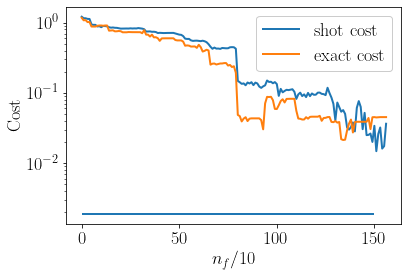

In [51]:
plt.plot(get_rolling_mins(scl) + 0.25, label="shot cost")
plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.hlines(opt_DHS, 0, 150)
plt.ylabel("Cost")
plt.legend()

In [47]:
opt_DHS = compute_optimal_DHS(rho, 2)

data_dict = {}
data_dict["backend"] = backend
data_dict["backend_name"] = backend.backend.name()
data_dict["rho"] = rho
data_dict["rho_circ"] = rho_prep_circ
data_dict["sigma"] = sigma
data_dict["final_cost"] = np.real(rho.purity() + sigma.purity() - 2 * np.trace(np.matmul(rho, sigma)))
data_dict["sigma_ansatz"] = ansatz
data_dict["params"] = params
data_dict["shot_costs"] = shot_cost
data_dict["exact_costs"] = exact_cost
data_dict["plot_offset"] = 0.25
data_dict["window"] = 10
data_dict["date"] = "26 June 2022"
data_dict["optimal_cost"] = opt_DHS

fname = "pickled_runs/nairobi_2q_ghz_prep_rank_2.pkl"
with open(fname, 'wb') as f:
    pickle.dump(data_dict, f)

/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_3740/3928646683.py:21: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dump(data_dict, f)
/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_3740/3928646683.py:21: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dump(data_dict, f)


In [52]:
with open("csv_runs/nairobi_2q_ghz_prep_rank_2.csv", 'w') as f:
    for j in range(len(scl)):
        f.write(f"{scl[j]},{ecl[j]}")